# Gestion de portefeuille - Part 1
François Goujon

Content : Stocks statistical analysis and portfolio optimization with Mean Variance Model.

### Table of Contents
* [Stat analysis](#stat)
    * [1 - Stock analysis](#stock)
        * [Functions](#stock_func)
        * [Plots](#stock_plots)
            
    * [2 - Market correlation](#stocks)
        * [Functions](#stocks_func)
        * [Plots](#stocks_plots)
            * [CAC40 top 10](#stocks_cac40_10)
            * [CAC40](#stocks_cac40)
    
* [Portfolio optimization](#pf)
    * [Functions](#pf_func)
    * [Results](#pf_res)
        * [Min variance model](#pf_minvar)
        * [Markovitz model](#pf_mark)
        * [Efficient Frontier](#pf_front)
        * [Portfolio Allocation](#pf_alloc)
        * [Add of risk free asset - Tangency Portfolio](#pf_tgt)

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Stat analysis <a class="anchor" id="stat"></a>
### 1 - Stock analysis : returns, volatility, autocorrelation <a class="anchor" id="stock"></a>
#### Functions <a class="anchor" id="stock_func"></a>

In [151]:
def get_data(ticker, start = None, end = None, days = 365, log = True, plot = False):
    """
    Retrieve data from yfinance
    Input: ticker (String)
    start : "2020-01-01", end: "2022-01-01"
    Output: price dataframe (pd.DataFrame)
    """
    if end is None:
        end = datetime.datetime.now()
    if start is None:
        start = end - datetime.timedelta(days=days+1)
    df = yf.Ticker(ticker).history(start=start, end=end, period="1d")
    df.index = df.index.to_series().dt.date # Remove hours, minutes and secondes
    df = df[["Close"]]
    if log:
        df["Returns"] = np.log(df["Close"].pct_change(1) + 1)
    else:
        df["Returns"] = df["Close"].pct_change(1)
    df["SquaredReturns"] = df["Returns"]**2
    df.dropna(inplace=True)
    if plot:
        plot_returns(df)
    return df

def plot_price(data):
    data[["Close"]].plot(figsize=(12,6))
    plt.show()

def plot_returns(df):
    fig, axs = plt.subplots(3, 1, figsize=(15, 7))
    df[["Close"]].plot(ax = axs[0])
    axs[0].set_ylabel("Price")
    df[["Returns"]].plot(ax = axs[1])
    axs[1].set_ylabel("1Day Return")
    df[["SquaredReturns"]].plot(ax = axs[2])
    axs[2].set_ylabel("1Day Squared Return")
    plt.show()

def hist_returns(df):
    n = len(df)
    fig, axs = plt.subplots(2, 1, figsize=(10, 7))
    weights = np.ones(n)/float(n)
    df[["Returns"]].hist(bins=30, ax = axs[0], weights=weights)
    axs[0].set_xlabel("Return")
    axs[0].set_ylabel("Density")
    df[["SquaredReturns"]].hist(bins=30, ax = axs[1], weights=weights)
    axs[1].set_xlabel("Squared Return")
    axs[1].set_ylabel("Density")
    plt.show()

def autocorr(x, method="pd"):
    def autocorr_np(x):
        result = np.correlate(x, x, mode='full')
        return result[result.size//2:][1:41]

    def autocorr_pd(x):
        ac = np.zeros(40)
        for lag in range(1, 41):
            ac[lag-1] = x.autocorr(lag)
        return ac
    ac = autocorr_np(x) if method=="np" else autocorr_pd(x)
    return ac

def autocorr_returns(df, method="pd", plot=True):
    ret = df["Returns"]
    ret2 = df["SquaredReturns"]
    absret = np.abs(ret)
    ac = autocorr(ret, method=method)
    ac2 = autocorr(ret2, method=method)
    absac = autocorr(absret, method=method)
    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(20, 4))
        for ax, ac_ in zip(axs, [ac, ac2, absac]):
            ax.grid()
            ax.scatter(list(range(1,41)), ac_)
            ax.bar(list(range(1,41)), ac_, width=0.1)
            ax.set_xlabel("Lag")
            ax.set_ylabel("Autocorr")
        axs[0].set_ylim([-0.2, 0.2])
        axs[1].set_ylim([-0.05, 0.3])
        axs[2].set_ylim([-0.05, 0.3])
        axs[0].set_title("Autocorr Returns")
        axs[1].set_title("Autocorr Squared Returns")
        axs[2].set_title("Autocorr Abs Returns")
        plt.plot()
    return ac, ac2, absac

def plot_volatility_window(df, window_days=40):
    """Plot volatility overtime by calculating it over a window_days window"""
    vol = df["Returns"].rolling(window=window_days).std()*np.sqrt(252)
    vol = vol.dropna()
    vol.plot(figsize=(10,3))
    plt.title("Volatility")
    plt.ylabel("Vol")
    plt.show()
    return vol

### Plots <a class="anchor" id="stock_plots"></a>

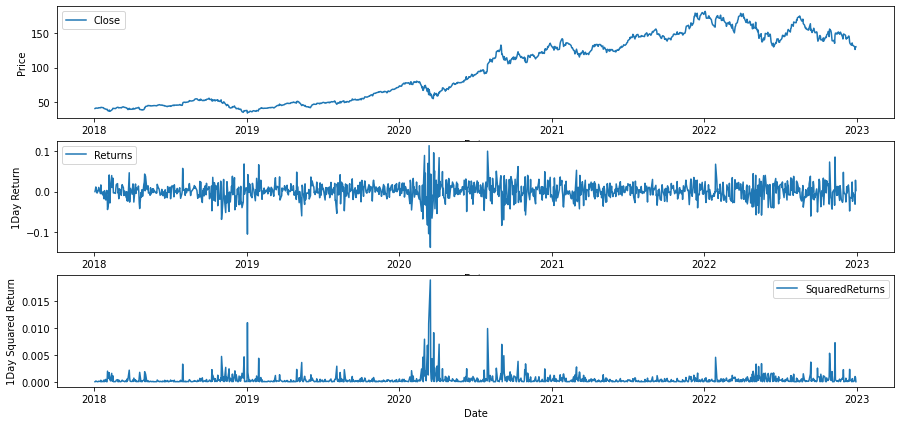

In [129]:
da = get_data("AAPL", start="2018-01-01", end="2023-01-01", plot=True)

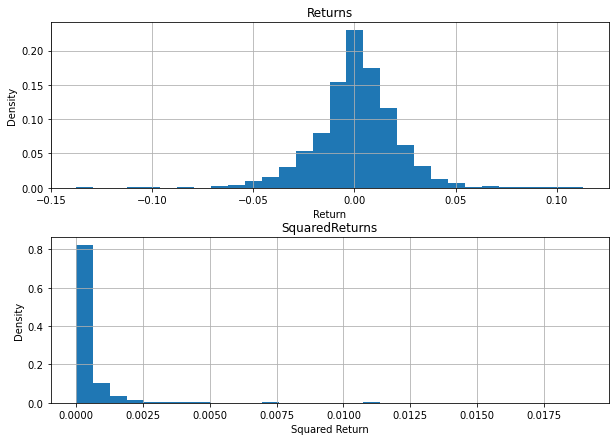

In [152]:
hist_returns(da) #Histogram

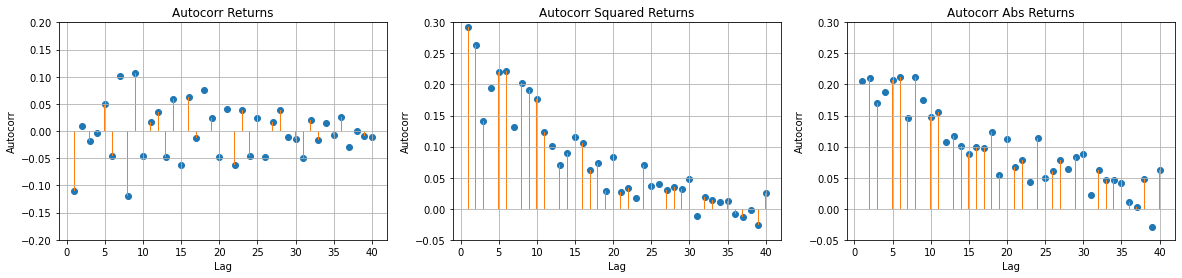

In [6]:
ac, ac2, absac = autocorr_returns(da) # Autocorrelation

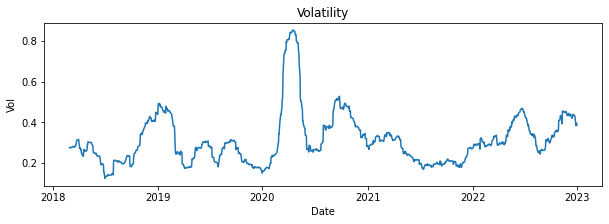

In [9]:
_ = plot_volatility_window(da)

## 2 - Market correlation <a class="anchor" id="stocks"></a>
#### Functions <a class="anchor" id="stocks_func"></a>

In [10]:
def get_index_data(index, start = None, end = None, days = 365, log=True):
    """
    Retrieve data from yfinance
    Input: indice (String)
    Output: price dataframe (pd.DataFrame)
    """
    compo_list = {"CAC40": ["MC.PA", "OR.PA", "RMS.PA", "TTE", "SNY", "AIR.PA", "SU.PA", "BNP.PA", "EL.PA", "AI.PA", "KER.PA",
                    "CS.PA", "DG.PA", "SAF.PA", "DSY.PA", "RI.PA", "STLA", "STM", "ACA.PA", "BN.PA", "ENGI.PA", "CAP.PA",
                    "SGO.PA", "ORAN", "HO.PA", "MT", "LR.PA", "ML.PA", "GLE.PA", "VIE.PA", "PUB.PA", "TEP.PA", "ERF.PA",
                    "WLN.PA", "CA.PA", "RNO.PA", "EN.PA", "ALO.PA", "VIV.PA", "URW.AS"],
                 "CAC40_short": ["MC.PA", "OR.PA", "RMS.PA", "TTE", "SNY", "AIR.PA", "SU.PA", "BNP.PA", "EL.PA", "AI.PA"]}

    tickers = " ".join(compo_list[index])
    if end is None:
        end = datetime.datetime.now()
    if start is None:
        start = end - datetime.timedelta(days=days+1)
    price_df = yf.Tickers(tickers).history(start=start, end=end, period="1d")
    price_df = price_df["Close"]
    if log:
        returns_df = np.log(price_df.pct_change(1) + 1)
    else:
        returns_df = price_df.pct_change(1)
    returns_df.dropna(inplace=True)
    squared_returns_df = returns_df**2
    dfs = {"price": price_df, "returns": returns_df, "squared_returns": squared_returns_df}
    return dfs

def mean_yearly_return(returns):
    myr = returns.mean()*252*100
    mean_df = myr.reset_index().rename(columns={"index":"Ticker", 0: "MeanYearlyReturn(%)"})
    return mean_df

def get_correlation(returns):
    return returns.corr()

def plot_correlation(corr):
    fig, ax = plt.subplots(figsize=(16,8))
    im = ax.matshow(corr)
    fig.colorbar(im, ax=ax)
    plt.show()

def get_maxmin_corr(corr):
    sorted_corr = corr.unstack().sort_values(ascending=False)
    scorr_df = sorted_corr.to_frame().reset_index().rename(columns={"level_0": "Ticker_1", "level_1":"Ticker_2", 0: "Correlation"})
    scorr_df = scorr_df[scorr_df["Correlation"] != 1]
    scorr_df = scorr_df.drop_duplicates(subset="Correlation")
    top = scorr_df.head(5)
    less = scorr_df.tail(5)
    res = pd.concat([top, less])
    return res

def plot_pca(corr):
    n = corr.shape[1] if corr.shape[1] < 10 else 10
    pca = PCA(n_components=n)
    pca.fit(corr)
    plt.figure(figsize=(15, 4))
    plt.bar(list(range(1,n+1)), pca.explained_variance_ratio_, label="Explained variance ratio")
    plt.plot(list(range(1,n+1)), pca.explained_variance_ratio_.cumsum(), "--", c="r", label="Cumulative explained variance ratio")
    plt.xlabel("Components")
    plt.ylabel("% Contribution")
    plt.title("PCA on correlation")
    plt.legend()
    plt.show()

def get_cov(returns):
    return returns.cov()

### Plots <a class="anchor" id="stocks_plots"></a>

In [115]:
cac = get_index_data("CAC40_short", start="2018-01-01", end="2023-01-01")
cacr = cac["returns"]
cac_22 = get_index_data("CAC40_short", start="2022-01-01", end="2023-01-01")
cacr_22 = cac_22["returns"]

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


#### Top 10 CAC40 <a class="anchor" id="stocks_cac40_10"></a>

In [12]:
mean_yearly_return(cacr)

,Ticker,MeanYearlyReturn(%)
0,AI.PA,10.422651
1,AIR.PA,7.233582
2,BNP.PA,4.007953
3,EL.PA,9.216837
4,MC.PA,21.943306
5,OR.PA,13.578591
6,RMS.PA,23.879102
7,SNY,6.120772
8,SU.PA,14.816548
9,TTE,8.322401


In [13]:
mean_yearly_return(cacr).sort_values("MeanYearlyReturn(%)", ascending=False).head(3) # TOP 3

,Ticker,MeanYearlyReturn(%)
6,RMS.PA,23.879102
4,MC.PA,21.943306
8,SU.PA,14.816548


In [14]:
corr = get_correlation(cacr)
corr

,AI.PA,AIR.PA,BNP.PA,EL.PA,MC.PA,OR.PA,RMS.PA,SNY,SU.PA,TTE
AI.PA,1.000000,0.473894,0.479489,0.519286,0.614407,0.595824,0.548995,0.382334,0.679198,0.387860
AIR.PA,0.473894,1.000000,0.638311,0.481315,0.556279,0.384200,0.456531,0.198542,0.558191,0.429404
BNP.PA,0.479489,0.638311,1.000000,0.490611,0.541354,0.390111,0.379183,0.256123,0.591696,0.579318
EL.PA,0.519286,0.481315,0.490611,1.000000,0.604746,0.570174,0.576623,0.222280,0.585629,0.272265
MC.PA,0.614407,0.556279,0.541354,0.604746,1.000000,0.665572,0.776090,0.286161,0.668246,0.430566
OR.PA,0.595824,0.384200,0.390111,0.570174,0.665572,1.000000,0.635634,0.318514,0.585209,0.286081
RMS.PA,0.548995,0.456531,0.379183,0.576623,0.776090,0.635634,1.000000,0.194735,0.601447,0.264854
SNY,0.382334,0.198542,0.256123,0.222280,0.286161,0.318514,0.194735,1.000000,0.324797,0.379230
SU.PA,0.679198,0.558191,0.591696,0.585629,0.668246,0.585209,0.601447,0.324797,1.000000,0.421730
TTE,0.387860,0.429404,0.579318,0.272265,0.430566,0.286081,0.264854,0.379230,0.421730,1.000000


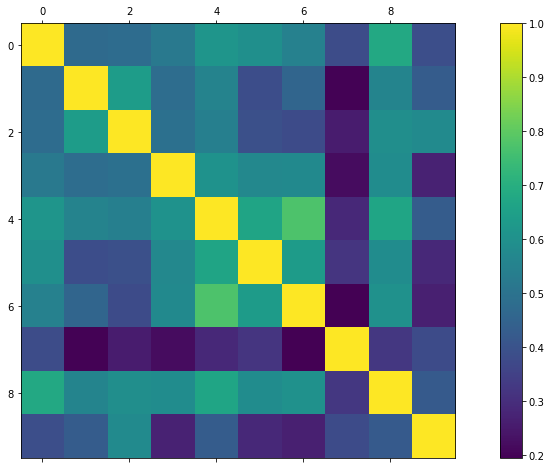

In [15]:
plot_correlation(corr)

#### CAC 40 <a class="anchor" id="stocks_cac40"></a>

[*********************100%***********************]  40 of 40 completed


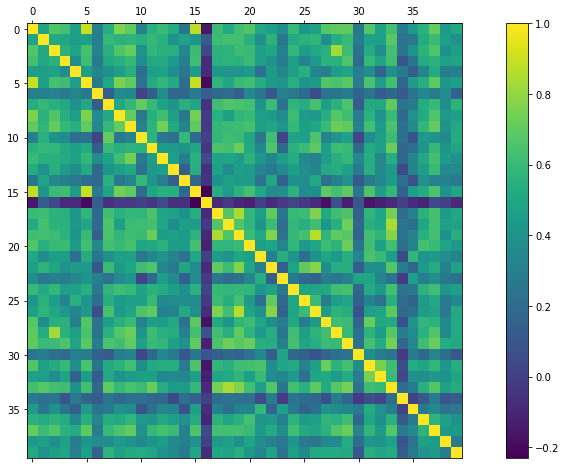

,Ticker_1,Ticker_2,Correlation
40,BNP.PA,ACA.PA,0.894527
42,BNP.PA,GLE.PA,0.892418
44,GLE.PA,ACA.PA,0.875622
46,RMS.PA,MC.PA,0.865716
48,MC.PA,KER.PA,0.844761
1590,ACA.PA,HO.PA,-0.153349
1592,HO.PA,STLA,-0.157696
1594,RNO.PA,HO.PA,-0.174810
1596,HO.PA,BNP.PA,-0.196557
1598,GLE.PA,HO.PA,-0.231234


In [72]:
corr_all = get_correlation(get_index_data("CAC40")["returns"])
plot_correlation(corr_all)
get_maxmin_corr(corr_all)

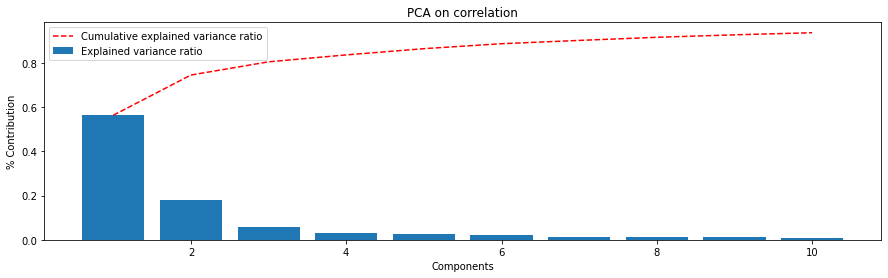

In [14]:
plot_pca(corr_all)

## Portfolio optimization <a class="anchor" id="pf"></a>

In [16]:
from cvxopt.solvers import qp
from cvxopt import matrix

#### Mean-Variance Model
$$
Returns : R_i \sim N(\mu_i, \sigma_i^2) \quad and \quad cov(R_i, R_j) = \sigma_{i,j} \ ; \ \Sigma = (\sigma_{i,j})\\
\quad \\
Weights : \sum w_i = 1 \\
\text{Expected return} : w^T\mu = \mu_w \quad and \quad \text{Variance} : w^T\Sigma w = \sigma_w^2 \\
\quad \\
\text{Portfolio return} : R_{p,w} \sim N(\mu_w, \sigma_w^2) \quad and \quad cov(R_{p,w_1}, R_{p,w_2}) = w_1^T\Sigma w_2
$$

#### Function qp from cvxopt : 
$$
\text{qp(P, q, G, h, A, b) resolves}:  \quad \quad \quad \quad \quad
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{min}}
& \frac{1}{2}x^T P x + q^T x \\
& \text{subject to}
\\
& & G x \leq h \\
& & A x = b
\end{aligned}
\end{equation*}

#### Functions <a class="anchor" id="pf_func"></a>

In [247]:
def get_mean_cov(returns):
    m = np.array(returns.mean())
    c = get_cov(returns).values
    return m, c

def get_names(returns):
    return returns.columns.to_list()  
    
def pf_opti(cov_ret, mean_ret, func = "min_var", exp_ret=None, rfr=0.0, short=False, verbose=False):
    nb_asset = cov_ret.shape[0]
    d_rfr = rfr/252
    true_ret = mean_ret - d_rfr
    p = cov_ret
    # PF optimization type
    if func == "min_var":
        q = np.zeros(nb_asset)
        eq_cond = True
    elif func == "max_sharpe":
        q = - true_ret
        eq_cond = False
    else:
        raise("Wrong func")
    # Weight positivity : If short allowed -> no condition 
    if short:
        g = np.zeros((nb_asset, nb_asset))
    else:
        g = -np.eye(nb_asset)
    h = np.zeros(nb_asset)
    # Markovitz model : Expected return
    if exp_ret is not None:
        d_er = exp_ret/252
        a_sum = np.ones((1,nb_asset), dtype=float)
        a_mu = true_ret
        a = np.vstack([a_sum, a_mu])
        b = np.array([1.0, d_er])
    else:
        a = np.ones((1,nb_asset), dtype=float)
        b = np.array([1.0]) 
    # QP solving
    if eq_cond: 
        params = [p, q, g, h, a, b]
    else:
        params = [p, q, g, h]
    params = list(map(matrix, params))
    sol = qp(*params, options={"show_progress":verbose})
    w = np.array(sol["x"]).ravel()
    if not eq_cond:
        w /= np.sum(w)
    if short:
        w[np.abs(w) < 0.005] = 0 # Cleaning small weights
    else:
        w[w < 0.005] = 0
        if np.abs(np.sum(w) - 1) > 0.05:
            w = np.zeros(nb_asset)
    return w

def get_pf_info(cov, mean, weights, verbose=True):
    mu_daily = weights@mean
    var_daily = (weights@cov)@weights
    mu = 252*mu_daily
    var = 252*var_daily
    std = np.sqrt(var)
    leverage = np.sum(np.abs(weights))
    if verbose:
        print(f"Expected yearly return = {round(mu, 3)} ; Expected var = {round(var, 3)} (std = {round(std,3)}) ; Leverage = {round(leverage,3)}")
    return mu, std

def frontier_compute(cov, mean, rfr = 0.0):
    arrs = {}
    arrs["mus"] = np.arange(0.0, 0.4, 0.005)
    arrs["weights_l"] = np.array([pf_opti(cov, mean, exp_ret=mu, rfr=rfr) for mu in arrs["mus"]])
    arrs["weights_ls"] = np.array([pf_opti(cov, mean, exp_ret=mu, rfr=rfr, short = True) for mu in arrs["mus"]])
    arrs["stds_l"] = np.array([get_pf_info(cov, mean, w, False)[1] for w in arrs["weights_l"]])
    arrs["stds_ls"] = np.array([get_pf_info(cov, mean, w, False)[1] for w in arrs["weights_ls"]])
    arrs["sharp_ratio_l"] = np.divide(arrs["mus"], arrs["stds_l"], where = arrs["stds_l"]!=0, out=np.zeros_like(arrs["mus"]))
    arrs["sharp_ratio_ls"] = np.divide(arrs["mus"], arrs["stds_ls"], where = arrs["stds_ls"]!=0, out=np.zeros_like(arrs["mus"]))
    return arrs

def plot_frontier(data):
    mus_l, mus_ls = data['mus'], data['mus']
    stds_l, stds_ls = data["stds_l"], data["stds_ls"]
    best_sharp_l = np.argmax(data["sharp_ratio_l"])
    best_sharp_ls = np.argmax(data["sharp_ratio_ls"])
    sharpe_mu_l, sharpe_std_l =  mus_l[best_sharp_l], stds_l[best_sharp_l]
    sharpe_mu_ls, sharpe_std_ls =  mus_ls[best_sharp_ls], stds_ls[best_sharp_ls]
    good_idx = stds_l>0
    stds_l, mus_l = stds_l[good_idx], mus_l[good_idx]
    best_idx_l, best_idx_ls = np.argmin(stds_l), np.argmin(stds_ls)
    print(f"Min Var Long only : mu = {mus_l[best_idx_l]} ; sigma = {round(stds_l[best_idx_l],3)}")
    print(f"Min Var Long Short : mu = {mus_ls[best_idx_ls]} ; sigma = {round(stds_ls[best_idx_ls],3)}")
    print(f"Max Sharpe Long only : mu = {sharpe_mu_l} ; sigma = {round(sharpe_std_l,3)}")
    print(f"Max Sharpe Long Short : mu = {sharpe_mu_ls} ; sigma = {round(sharpe_std_ls,3)}")
    plt.figure(figsize=(7, 5))
    plt.plot(stds_l, mus_l, ".", label="Long only", c="b")
    plt.plot(stds_ls, mus_ls, ".", label="Long Short", c="r")
    plt.xlabel(r"$\sigma$")
    plt.ylabel("Expected return")
    plt.xlim([0, 0.4])
    plt.show()

def plot_efficient_allocation(data, names):
    alloc_l = pd.DataFrame(data["weights_l"], index=data["stds_l"].round(2), columns=names)
    alloc_ls = pd.DataFrame(data["weights_ls"], index=data["stds_ls"].round(2), columns=names)
    fig, axs = plt.subplots(2, 1, figsize=(16, 8))
    alloc_l.plot(kind='bar', stacked=True, ax=axs[0])
    alloc_ls.plot(kind='bar', stacked=True, ax=axs[1])
    for ax in axs:
        ax2 = ax.twiny()
        ax2.set_xticks(ticks=ax.get_xticks(), labels=data["mus"].round(2), rotation=45)
        ax2.set_xlabel(r"$\mu$")
        ax.set_ylabel('Allocation')
        ax.set_xlabel(r"$\sigma$")
        ax.legend(title='Tickers', bbox_to_anchor=(1.0, 1), loc='upper left')
    axs[0].set_ylim([0, 1])
    axs[1].set_ylim([-1, 2])
    plt.tight_layout()
    plt.show()

def plot_tangent_allocation(weights_t, cov, mean, rfr, names):
    mu, std = get_pf_info(cov, mean, weights_t, False)
    alphas = np.arange(0, 1.4, 0.05)
    allocs = [weights_t*alpha for alpha in alphas]
    cash = 1 - alphas
    stds = std*alphas
    mus = (1-alphas)*rfr + alphas*mu
    # Create df
    alloc_df = pd.DataFrame(allocs, index=stds.round(2), columns=names)
    # Add cash 
    alloc_df["Cash"] = cash
    # Fig
    fig, ax = plt.subplots(figsize=(10, 5))
    alloc_df.plot(kind='bar', stacked=True, ax=ax)
    ax2 = ax.twiny()
    ax2.set_xticks(ticks=ax.get_xticks(), labels=mus.round(2), rotation=45)
    ax2.set_xlabel(r"$\mu$")
    ax.set_ylabel('Allocation')
    ax.set_xlabel(r"$\sigma$")
    ax.legend(title='Tickers', bbox_to_anchor=(1.0, 1), loc='upper left')
    #ax.set_ylim([-4, 4])
    plt.tight_layout()
    plt.show()


### Results <a class="anchor" id="pf_res"></a>

In [116]:
mean_r, cov_r = get_mean_cov(cacr)
names = get_names(cacr)
mean_r_22, cov_r_22 = get_mean_cov(cacr_22)

#### Min Variance Portfolio <a class="anchor" id="pf_minvar"></a>

$$
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{min}}
& w^T\Sigma w \\
& \text{subject to}
\\
& &  1^T w = 1 \\
& & \text{if long only : } \forall i,\ w_i \geq 0 
\end{aligned}
\end{equation*}
$$
This is "min_var" option of pf_opti with exp_ret = None

In [227]:
w = pf_opti(cov_r, mean_r, func="min_var")
print(w.round(3))
_= get_pf_info(cov_r, mean_r, w)
print(round(sum(w), 3))

[0.28  0.    0.    0.116 0.    0.104 0.12  0.347 0.    0.03 ]
Expected yearly return = 0.106 ; Expected var = 0.03 (std = 0.173) ; Leverage = 0.997
0.997


In [228]:
w = pf_opti(cov_r, mean_r, func="min_var", short=True)
print(w.round(3))
_= get_pf_info(cov_r, mean_r, w)
print(round(sum(w), 3))

[ 0.348 -0.04   0.034  0.16  -0.196  0.145  0.253  0.328 -0.101  0.068]
Expected yearly return = 0.098 ; Expected var = 0.028 (std = 0.168) ; Leverage = 1.673
1.0


#### Markovitz Model <a class="anchor" id="pf_mark"></a>
$$
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{min}}
& w^T\Sigma w \\
& \text{subject to}
\\
& & \mu^T w = \mu^* \\
& & 1^T w = 1 \\
& & \text{if long only : } \forall i,\ w_i \geq 0
\end{aligned}
\end{equation*}
$$
This is "min_var" option of pf_opti with exp_ret = $\mu^*$

In [229]:
w = pf_opti(cov_r, mean_r, exp_ret=0.2)
print(w.round(3))
_= get_pf_info(cov_r, mean_r, w)
print(round(sum(w), 3))

[0.032 0.    0.    0.    0.047 0.006 0.73  0.185 0.    0.   ]
Expected yearly return = 0.2 ; Expected var = 0.048 (std = 0.218) ; Leverage = 0.999
0.999


In [230]:
w = pf_opti(cov_r, mean_r, exp_ret=0.2, short=True)
print(w.round(3))
_= get_pf_info(cov_r, mean_r, w)
print(round(sum(w), 3))

[ 0.193 -0.116 -0.108 -0.041  0.087  0.046  0.618  0.213  0.023  0.084]
Expected yearly return = 0.2 ; Expected var = 0.043 (std = 0.208) ; Leverage = 1.529
1.0


#### Efficient frontier <a class="anchor" id="pf_front"></a>

Min Var Long only : mu = 0.1 ; sigma = 0.173
Min Var Long Short : mu = 0.1 ; sigma = 0.168
Max Sharpe Long only : mu = 0.225 ; sigma = 0.243
Max Sharpe Long Short : mu = 0.325 ; sigma = 0.318


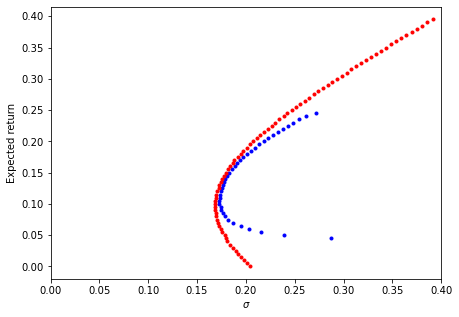

In [232]:
frontier_data = frontier_compute(cov_r, mean_r)
plot_frontier(frontier_data)

Min Var Long only : mu = 0.08 ; sigma = 0.173
Min Var Long Short : mu = 0.08 ; sigma = 0.168
Max Sharpe Long only : mu = 0.23 ; sigma = 0.267
Max Sharpe Long Short : mu = 0.335 ; sigma = 0.349


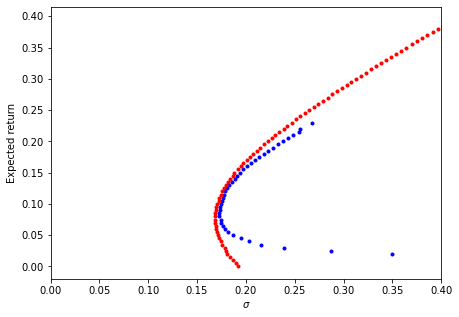

In [233]:
frontier_data_rfr = frontier_compute(cov_r, mean_r, rfr=0.02) # Shift figure down
plot_frontier(frontier_data_rfr)

Min Var Long only : mu = 0.0 ; sigma = 0.191
Min Var Long Short : mu = 0.01 ; sigma = 0.186
Max Sharpe Long only : mu = 0.29 ; sigma = 0.336
Max Sharpe Long Short : mu = 0.395 ; sigma = 0.299


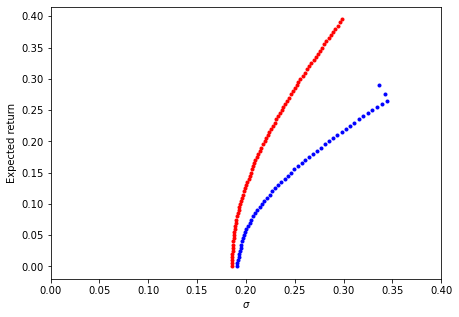

In [234]:
frontier_data_22 = frontier_compute(cov_r_22, mean_r_22)
plot_frontier(frontier_data_22)

#### Portfolio Allocation <a class="anchor" id="pf_alloc"></a>

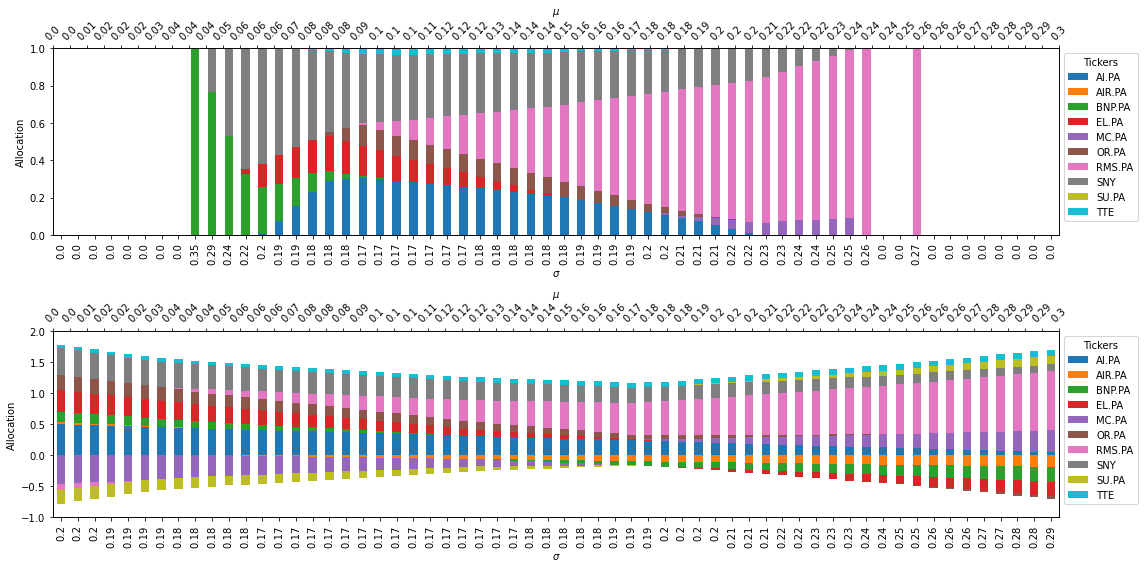

In [52]:
plot_efficient_allocation(frontier_data, names)

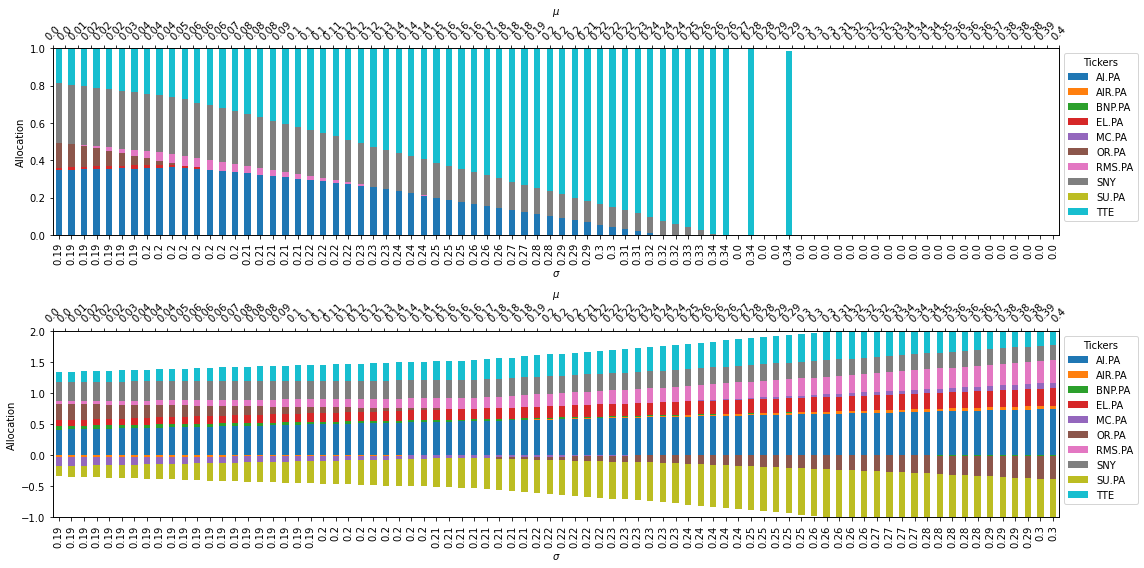

In [127]:
plot_efficient_allocation(frontier_data_22, names)

#### Addition of a risk free asset - Tangency Portfolio <a class="anchor" id="pf_tgt"></a>
$$
\texttt{\small{Risk free asset}} : \mu = r_f \quad and \quad \sigma = 0 \\
\texttt{\small{The tangency portfolio corresponds to the point on the efficient frontier where the slope of the}} \\
\texttt{\small{tangent passing throught r is maximized. Slope : }} \frac{\mu_p - r_f}{\sigma_p} \texttt{\small{. Indeed, we will build a pf composed of : }} \\
\quad \\
(1-\alpha) * RiskFreeAsset \ + \alpha *TangencyPF \texttt{\small{ so that : }}\\
\texttt{\small{Expected return = }}(1-\alpha) r_f + \alpha \mu_p \\
\texttt{\small{std = }} \alpha \sigma_p \\
\quad \\
\texttt{\small{The optimization problem is : }} \\
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{max}}
& \frac{\mu_p - r_f}{\sigma_p}\\
& \text{subject to}
\\
& &  1^T w = 1 \\
\end{aligned}
\end{equation*}
\\ 
\texttt{\small{Finding an equivalent problem : }} \\ \frac{\mu_p - r_f}{\sigma_p} = \frac{w^T \mu - r_f}{\sqrt{w^T \Sigma w}} = \frac{w^T (\mu - R_f)}{\sqrt{w^T \Sigma w}} = \frac{w^T \tilde{\mu}}{\sqrt{w^T \Sigma w}} \quad with \ R_f = [r_f \ r_f \ ... \ r_f]^T \ and \ \tilde{\mu} = \mu - R_f \quad (w^T R_f = r_f \ as \sum w_i = 1) \\
\Rightarrow
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{max}}
& \frac{w^T \tilde{\mu}}{\sqrt{w^T \Sigma w}}\\
& \text{subject to}
\\
& &  1^T w = 1 \\
\end{aligned}
\end{equation*}
\\ 
\texttt{\small{We can see in this expression that the value is unchanged when w is multiplied by a constant,}} \\
\texttt{\small{we can maximize to find w and then normalize to 1}} \\ 
\texttt{\small{This becomes : }} \\
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{min}}
& w^T \Sigma w \\
& \text{subject to}
\\
& & \tilde{\mu}^T w = \mu^* \\
\end{aligned}
\end{equation*}
\quad 
\text{ , for any } \mu^* > 0 \text{ and then } w = \frac{w}{sum(w)} \\
\texttt{\small{Which is equivalent to : }} \\
\underset{w}{\text{min}} \ w^T \Sigma w - \tilde{\mu}^T w \quad \text{ , and then } w = \frac{w}{sum(w)}\\
$$
This is "max_sharpe" func option of pf_opti.

In [248]:
w_tpf = pf_opti(cov_r, mean_r, func="max_sharpe", rfr = 0.02)
print(w_tpf.round(3))
_= get_pf_info(cov_r, mean_r, w_tpf)
print(round(sum(w_tpf), 3))

[0.    0.    0.    0.    0.092 0.    0.902 0.005 0.    0.   ]
Expected yearly return = 0.236 ; Expected var = 0.065 (std = 0.256) ; Leverage = 1.0
1.0


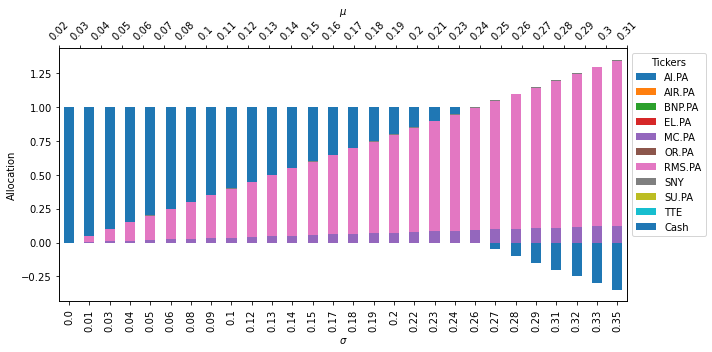

In [249]:
plot_tangent_allocation(w_tpf, cov_r, mean_r, 0.02, names)

In [250]:
w_tpf = pf_opti(cov_r, mean_r, func="max_sharpe", rfr = 0.02, short=True)
print(w_tpf.round(3))
_= get_pf_info(cov_r, mean_r, w_tpf)
print(round(sum(w_tpf), 3))

[-0.045 -0.233 -0.324 -0.349  0.521 -0.106  1.178  0.038  0.213  0.108]
Expected yearly return = 0.357 ; Expected var = 0.123 (std = 0.351) ; Leverage = 3.116
1.0


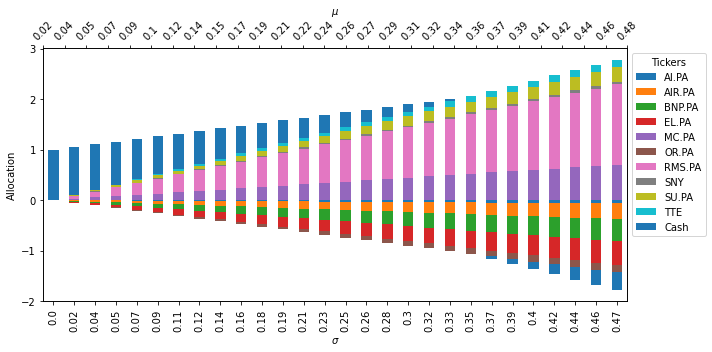

In [251]:
plot_tangent_allocation(w_tpf, cov_r, mean_r, 0.02, names)